# <span style="color:blue">Pre-analysis to find the optimal number of topics and hyperparameters values (2019_Aug)</span>

In [1]:
yyyy_MMM = '2019_Aug'

### Load packages

In [2]:
import csv, os, re, time
import numpy as np
import pandas as  pd
import matplotlib.pyplot as plt  
import pyLDAvis
import pyLDAvis.gensim
import gensim
import gensim.corpora as corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel
from gensim.models import Phrases
from gensim.test.utils import datapath
from gensim.utils import simple_preprocess
from pprint import pprint
import nltk
nltk.download('stopwords')

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\botocore\vendored\requests\packages\urllib3\_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\botocore\vendored\requests\packages\urllib3\_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\models\doc

True

### Constants

In [3]:
# for reproducible results
random_state = 33
# if debug is True, messages during the process are generated
debug = False
# for debugging purposes sample may be used to work with a smaller amount of data (when 0 it is not applied)
sample = 0
# if the test is True, the process runs on a smaller subset of raw data (json files)
test = True

if test:
    # path where the doc files are stored
    path_doc = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins_test\doc'
    # path where the model files are stored
    path_model = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins_test\model_hyperparameter'
    # LDA chunksize
    chunksize = 250
else:
    # path where the doc files are stored
    path_doc = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins\doc'
    # path where the model files are stored
    path_model = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins\model_hyperparameter'
    # LDA chunksize
    chunksize = 5000

file_doc = os.path.join(path_doc, yyyy_MMM, yyyy_MMM) + '_28_results.csv'
file_model = os.path.join(path_model, yyyy_MMM, 'model')
print(file_doc)
print(file_model)

D:\master\data science\semestre 4\M2.979 - tfm\data\bins_test\doc\2019_Aug\2019_Aug_28_results.csv
D:\master\data science\semestre 4\M2.979 - tfm\data\bins_test\model_hyperparameter\2019_Aug\model


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Load data preprocessed

In [4]:
df = pd.read_csv(file_doc)
documents = df.content_preprocessed
documents.head(10)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    ['sophie', 'chou', 'pose', 'shutterbug', 'mani...
1    ['francis', 'sunshine', 'mixed', 'hurricane', ...
2    ['permanent', 'mood', 'transcendent', 'nationa...
3    ['love', 'story', 'write', 'torn', 'chapter', ...
4    ['medium', 'calendar', 'credit', 'intro', 'ran...
5                        ['legendary', 'shot', 'star']
6    ['leg', 'day', 'hotshot', 'werker', 'knee', 'l...
7    ['gerald', 'huston', 'gettin', 'number', 'guid...
8    ['barba', 'cabelo', 'david', 'habibi', 'blog',...
9    ['garnier', 'hydra', 'bomb', 'aqua', 'bomb', '...
Name: content_preprocessed, dtype: object

### Shuffle

In [5]:
documents = documents.sample(frac=1, random_state=random_state)
documents.head(10)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1805    ['erie', 'bistrot', 'dans', 'ignoble', 'entre'...
1852    ['feel', 'mama', 'special', 'juicy', 'couture'...
1205    ['sound', 'card', 'braid', 'hotshot', 'card', ...
863     ['stylish', 'karan', 'wahi', 'kareena', 'kapoo...
1765    ['ranbir', 'kapoor', 'snap', 'mumbai', 'today'...
1377    ['connie', 'tag', 'repost', 'connie', 'fashion...
1275    ['cowgirl', 'rodeo', 'chance', 'inno', 'beukes...
1725    ['urvashi', 'walk', 'ramp', 'pink', 'peacock',...
760     ['perfectly', 'flawless', 'exclusively', 'bayo...
520                         ['cassi', 'bagley', 'follow']
Name: content_preprocessed, dtype: object

### Sample

In [6]:
if sample > 0:
    documents = documents.sample(n=sample, random_state=random_state)
    print(documents.head(10))

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Tokenize words and Clean-up text  
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#3importpackages

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Function to compute bigrams & trigrams  
https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#pre-process-and-vectorize-the-documents

In [8]:
# Add bigrams and trigrams to docs (only ones that appear min_count times or more).
def bi_tri_grams(documents, min_count):
    bigram = Phrases(documents, min_count=min_count)
    for idx in range(len(documents)):
        for token in bigram[documents[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                documents[idx].append(token)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Function for categorizing and tagging words

In [9]:
def tag_words(text):
    tags = nltk.pos_tag(text)
    nouns = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]
    return nouns

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Analysis to get the optimal number of topics  
https://towardsdatascience.com/discover-what-singaporeans-generally-talk-on-sms-d4b592a682fd

In [10]:
data_words = list(sent_to_words(documents))
# Compute bigrams & trigrams
bi_tri_grams(data_words, 250)
# Categorizing and tagging words
data_words = list(map(tag_words, data_words))
# Create Dictionary
id2word = Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
model_list = []
coherence_score = []
model_topics = []

for num_topics in range(8, 25, 2):
    
    time_start = time.time()

    lda_x = gensim.models.LdaMulticore(corpus=corpus
                                       ,id2word=id2word
                                       ,num_topics=num_topics
                                       ,random_state=random_state
                                       ,chunksize=chunksize
                                       ,passes=10)
    coherence_lda_model = CoherenceModel(model=lda_x, texts=data_words, dictionary=id2word, coherence='c_v')
    coherence = coherence_lda_model.get_coherence()
    coherence_score.append(coherence)
    model_topics.append(num_topics)
    model_list.append(lda_x)
    
    print("# Topics: " + str(num_topics) + " Score: " + str(coherence))
    
    time_end = time.time()
    hour, rem = divmod(time_end - time_start, 3600)
    minute, second = divmod(rem, 60)
    print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Topics: 8 Score: 0.5768505554173666
time elapsed - 00:00:21.33
# Topics: 10 Score: 0.5949623249537482
time elapsed - 00:00:21.11
# Topics: 12 Score: 0.5576386481765631
time elapsed - 00:00:20.79
# Topics: 14 Score: 0.5552797327190007
time elapsed - 00:00:20.60
# Topics: 16 Score: 0.581861990927572
time elapsed - 00:00:21.44
# Topics: 18 Score: 0.5721607090910447
time elapsed - 00:00:20.99
# Topics: 20 Score: 0.5458402328592625
time elapsed - 00:00:22.12
# Topics: 22 Score: 0.5533640986638939
time elapsed - 00:00:20.84
# Topics: 24 Score: 0.5698133102726146
time elapsed - 00:00:20.42


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


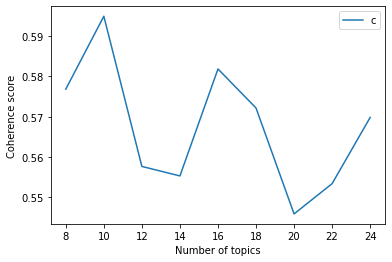

In [12]:
limit=25; start=8; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_score)
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Hyperparameter tuning  

https://medium.com/analytics-vidhya/analyzing-amazon-tv-reviews-with-latent-dirichlet-allocation-97d19c3bb878  
https://github.com/Georgebob256/Machine-learning-with-Python/blob/master/Amazon%20TV%20reviews..ipynb

In [13]:
# LDA model and its corresponding Coherence Score
def compute_coherence_values(bow_corpus, id2word, n, a, b):
    lda_model = gensim.models.LdaMulticore(corpus=bow_corpus
                                           ,id2word=id2word
                                           ,num_topics=n
                                           ,random_state=random_state
                                           ,chunksize=chunksize
                                           ,passes=10
                                           ,alpha=a
                                           ,eta=b)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
    return coherence_model_lda.get_coherence()

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 8
max_topics = 25
step_size = 2
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = [0.01, 0.31, 0.61, 0.91, 'symmetric', 'asymmetric']

# Beta parameter
beta = [0.01, 0.31, 0.61, 0.91, 'symmetric']

model_results = {'Topics': []
                 ,'Alpha': []
                 ,'Beta': []
                 ,'Coherence': []
                }

# iterate through number of topics
iter = 0
for k in topics_range:
    # iterate through alpha values
    for a in alpha:
        # iterare through beta values
        for b in beta:
            iter += 1
            # get the coherence score for the given parameters
            cv = compute_coherence_values(bow_corpus=corpus
                                          ,id2word=id2word
                                          ,n=k
                                          ,a=a
                                          ,b=b)
            # Save the model results
            model_results['Topics'].append(k)
            model_results['Alpha'].append(a)
            model_results['Beta'].append(b)
            model_results['Coherence'].append(cv)
            print('Iteration num - ', iter, ' Topics - ', k, ' Alpha - ', a, ' Beta - ', b, ' Coherence - ', cv)

pd.DataFrame(model_results).to_csv(file_model + '_lda_tuning_results.csv', index=False)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Iteration num -  1  Topics -  8  Alpha -  0.01  Beta -  0.01  Coherence -  0.5680892076184201
Iteration num -  2  Topics -  8  Alpha -  0.01  Beta -  0.31  Coherence -  0.6056567935793973
Iteration num -  3  Topics -  8  Alpha -  0.01  Beta -  0.61  Coherence -  0.6116895604864563
Iteration num -  4  Topics -  8  Alpha -  0.01  Beta -  0.91  Coherence -  0.6400878818859519
Iteration num -  5  Topics -  8  Alpha -  0.01  Beta -  symmetric  Coherence -  0.5643792501486404
Iteration num -  6  Topics -  8  Alpha -  0.31  Beta -  0.01  Coherence -  0.5826735034775188
Iteration num -  7  Topics -  8  Alpha -  0.31  Beta -  0.31  Coherence -  0.575187597067656
Iteration num -  8  Topics -  8  Alpha -  0.31  Beta -  0.61  Coherence -  0.5773172316086446
Iteration num -  9  Topics -  8  Alpha -  0.31  Beta -  0.91  Coherence -  0.6074151190605588
Iteration num -  10  Topics -  8  Alpha -  0.31  Beta -  symmetric  Coherence -  0.5675234801331654
Iteration num -  11  Topics -  8  Alpha -  0.61  B

Iteration num -  85  Topics -  12  Alpha -  symmetric  Beta -  symmetric  Coherence -  0.607891484175565
Iteration num -  86  Topics -  12  Alpha -  asymmetric  Beta -  0.01  Coherence -  0.5971741355667471
Iteration num -  87  Topics -  12  Alpha -  asymmetric  Beta -  0.31  Coherence -  0.5859623566157798
Iteration num -  88  Topics -  12  Alpha -  asymmetric  Beta -  0.61  Coherence -  0.5627293999906975
Iteration num -  89  Topics -  12  Alpha -  asymmetric  Beta -  0.91  Coherence -  0.5448422341314528
Iteration num -  90  Topics -  12  Alpha -  asymmetric  Beta -  symmetric  Coherence -  0.5860887251046412
Iteration num -  91  Topics -  14  Alpha -  0.01  Beta -  0.01  Coherence -  0.5486587011058248
Iteration num -  92  Topics -  14  Alpha -  0.01  Beta -  0.31  Coherence -  0.5292848882816186
Iteration num -  93  Topics -  14  Alpha -  0.01  Beta -  0.61  Coherence -  0.5390702001713751
Iteration num -  94  Topics -  14  Alpha -  0.01  Beta -  0.91  Coherence -  0.5588350172003

Iteration num -  168  Topics -  18  Alpha -  0.91  Beta -  0.61  Coherence -  0.5833162892107535
Iteration num -  169  Topics -  18  Alpha -  0.91  Beta -  0.91  Coherence -  0.5500170363464246
Iteration num -  170  Topics -  18  Alpha -  0.91  Beta -  symmetric  Coherence -  0.5540928154098181
Iteration num -  171  Topics -  18  Alpha -  symmetric  Beta -  0.01  Coherence -  0.586879573179676
Iteration num -  172  Topics -  18  Alpha -  symmetric  Beta -  0.31  Coherence -  0.5448263234585574
Iteration num -  173  Topics -  18  Alpha -  symmetric  Beta -  0.61  Coherence -  0.5832932039628065
Iteration num -  174  Topics -  18  Alpha -  symmetric  Beta -  0.91  Coherence -  0.5559954163191567
Iteration num -  175  Topics -  18  Alpha -  symmetric  Beta -  symmetric  Coherence -  0.564411434871246
Iteration num -  176  Topics -  18  Alpha -  asymmetric  Beta -  0.01  Coherence -  0.5757430569132046
Iteration num -  177  Topics -  18  Alpha -  asymmetric  Beta -  0.31  Coherence -  0.55

Iteration num -  251  Topics -  24  Alpha -  0.61  Beta -  0.01  Coherence -  0.5997828224457513
Iteration num -  252  Topics -  24  Alpha -  0.61  Beta -  0.31  Coherence -  0.5322959487829201
Iteration num -  253  Topics -  24  Alpha -  0.61  Beta -  0.61  Coherence -  0.5254782196820011
Iteration num -  254  Topics -  24  Alpha -  0.61  Beta -  0.91  Coherence -  0.5832287575155045
Iteration num -  255  Topics -  24  Alpha -  0.61  Beta -  symmetric  Coherence -  0.589076683235514
Iteration num -  256  Topics -  24  Alpha -  0.91  Beta -  0.01  Coherence -  0.5724313663650896
Iteration num -  257  Topics -  24  Alpha -  0.91  Beta -  0.31  Coherence -  0.5370023192353158
Iteration num -  258  Topics -  24  Alpha -  0.91  Beta -  0.61  Coherence -  0.565227038874552
Iteration num -  259  Topics -  24  Alpha -  0.91  Beta -  0.91  Coherence -  0.5510067298300347
Iteration num -  260  Topics -  24  Alpha -  0.91  Beta -  symmetric  Coherence -  0.5644936685369782
Iteration num -  261  

In [14]:
pd.DataFrame(model_results).sort_values(by=['Coherence'], ascending=False)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topics,Alpha,Beta,Coherence
28,8,asymmetric,0.91,0.685498
27,8,asymmetric,0.61,0.664021
26,8,asymmetric,0.31,0.654972
29,8,asymmetric,symmetric,0.654484
18,8,0.91,0.91,0.646223
...,...,...,...,...
184,20,0.01,symmetric,0.515977
192,20,0.61,0.61,0.515738
222,22,0.61,0.61,0.514507
237,22,asymmetric,0.61,0.512320
